# Microscope Setup Tutorial for G4LumaCam
Tsviki Y. Hirsh

July 23rd 2025

This tutorial guides you through setting up a high-performance microscope configuration for the G4LumaCam simulation. 

The setup uses two front-to-front lenses: 
- a Nikkor 80-200mm f/2.8 AF-S zoom lens
- Nikkor 50mm f/1.4 lens

Achieving a magnification range of 1.6x to 4x. 


In [1]:
%pylab inline
import lumacam

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Simulate a source of opticalphotons
We will be using this to focus our microscope setup. The opticalphotons are emitted from the scintillator surface in a 2x2 mm square

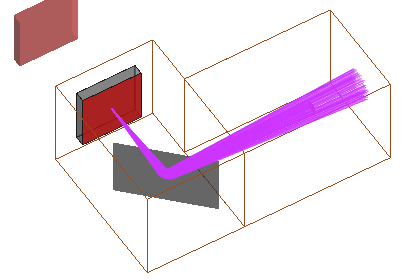

In [2]:
sim = lumacam.Simulate("archive/microscope_photons")
config = lumacam.Config.opticalphoton_uniform()
config.halfx = 1
config.halfy = 1
config.num_events = 10000
config

Configuration:
  Particle: opticalphoton
  Energy: 3 eV
  Position: (0, 0, 20) mm
  Direction: (0, 0, 1)
  Shape: Rectangle (1x1 mm)
  Angle: iso (max theta: 180 deg)
  Sample Material: G4_Galactic
  Sample Thickness: 20 cm
  Scintillator: EJ200
  Scintillator Thickness: 20 cm
  Events: 10000
  Output: sim_data.csv

In [3]:
df = sim.run(config)

Simulating:   0%|          | 0/10000 [00:00<?, ?events/s]

# Define the microscope lens
As simple as calling the Lens object with `kind="microscope"`.

We use the plot method to show the lens assembly.

The microscope setup has the 50mm lens on the left side and the larger 80-200mm lens on the right side

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


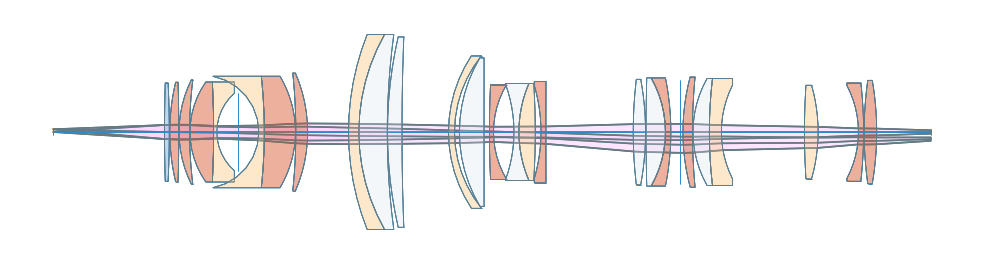

In [4]:
lens = lumacam.Lens("archive/microscope_photons",kind="microscope")
lens.plot()

We can use the "spot" plot to see that the lens is not focused

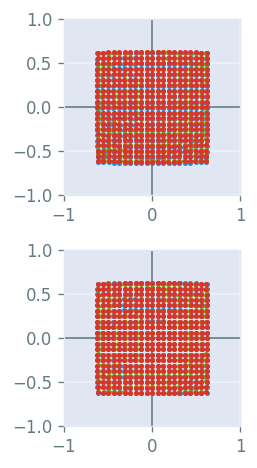

In [5]:
lens.plot(kind="spot",scale=1)

We can now use the refocus method to change the focus of this assembly

- zscan [mm]: controls the distance of the lens from the light source or object
- zfine [mm]: controls the position of the focus lens dial to change the focus from 80mm to the maximum 200mm 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


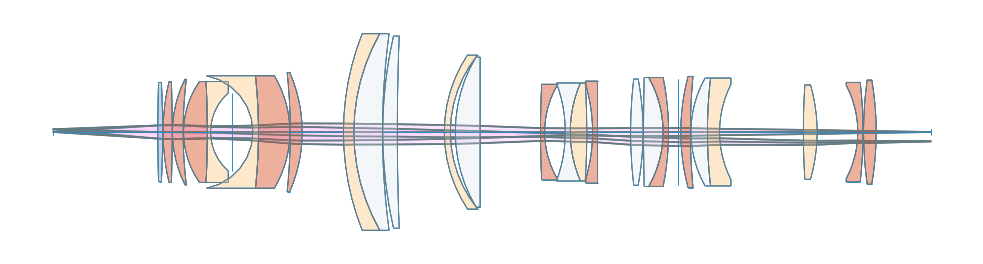

In [6]:
opm = lens.refocus(zscan=-2.8,zfine=20)
lens.plot(opm)

Looks much better now

Let's check the spot plot

The results look promising. Some chromatic astigmatism is present, but it's on the order of 10 μm, which should be acceptable our application

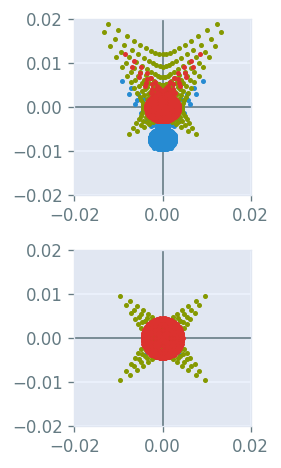

In [7]:
lens.plot(opm,kind="spot",scale=0.02)

# trace rays through

We pass the refocused `opm` object and use the trace_rays method to trace the opticalphotons through the microscope

In [8]:
data = lens.trace_rays(opm=opm,return_df=True,join=True)

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/10 [00:00<?, ?it/s]

The microscope has increased the uniform light source x3

Text(0.5, 1.0, 'opticalphotons')

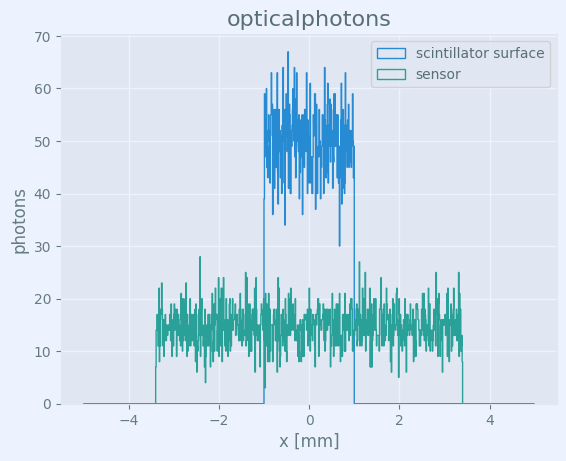

In [9]:
data.plot.hist(y=["x","x2"],histtype="step",bins=arange(-5,5,0.01),xlabel="x [mm]",ylabel="photons")
legend(["scintillator surface","sensor"]); title("opticalphotons")

# Analyse using `empir`
These are only opticalphotons but we can still try and reconstruct those, we use the `process_data_event_by_event` method and set the FOV as 2mm, this is actually the lighted scintillator area, we set the focus_factor to 3 to translate between the pixel numbers that empir photon2image provides and the actual image dimensions

In [10]:
analysis = lumacam.Analysis("archive/microscope_photons")
result = analysis.process_data_event_by_event(dSpace_px=1,merge=True,fov=2,focus_factor=3)

Loading traced data:   0%|          | 0/1 [00:00<?, ?it/s]

Loading sim data:   0%|          | 0/1 [00:00<?, ?it/s]

Processing neutron events:   0%|          | 0/1 [00:00<?, ?it/s]

This method provides a merged dataframe that has all the information about each opticalphoton

Let's plot the reconstructed profile. There's seems to be a nice match between the original and reconstructed positions

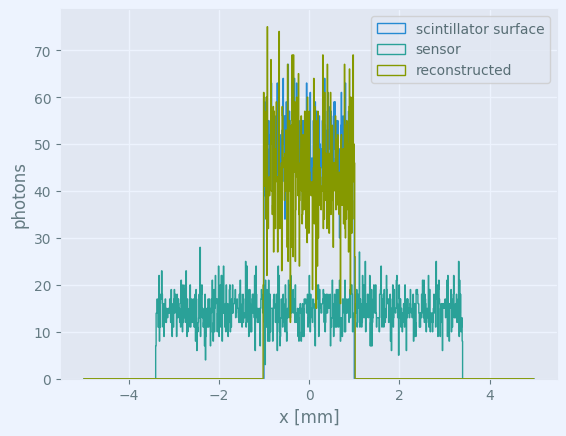

In [11]:
result.plot.hist(y=["x","x2","x3"],histtype="step",bins=arange(-5,5,0.01),xlabel="x [mm]",ylabel="photons")
legend(["scintillator surface","sensor","reconstructed"])

# Simulate neutrons
Now let's see how all this works for neutron interactions. Here we simulate 10 MeV neutrons that impinge on a 20mm EJ-200 scintillator with a square collimated area of 2x2 mm. This results in a lot more photons

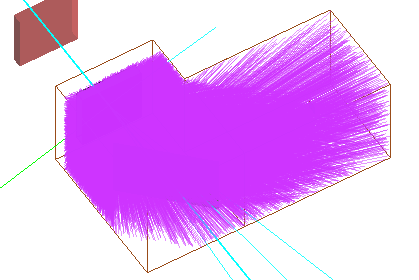

In [12]:
sim = lumacam.Simulate("archive/microscope_neutrons")
config = lumacam.Config.neutrons_uniform()
config.halfx = 1
config.halfy = 1
config.num_events = 10000
config.sample_material = "G4_Galactic"
config

Configuration:
  Particle: neutron
  Energy: 10.0 MeV
  Position: (0, 0, -1059) cm
  Direction: (0, 0, 1)
  Shape: Rectangle (1x1 mm)
  Angle: iso (max theta: 0 deg)
  Sample Material: G4_Galactic
  Sample Thickness: 20 cm
  Scintillator: EJ200
  Scintillator Thickness: 20 cm
  Events: 10000
  Output: sim_data.csv

In [13]:
df = sim.run(config)

Simulating:   0%|          | 0/10000 [00:00<?, ?events/s]

FileNotFoundError: No valid (non-empty) CSV files found in archive/microscope_neutrons/SimPhotons

Load the microscope for that archive as well and trace the rays through

In [ ]:
lens = lumacam.Lens("archive/microscope_neutrons/",kind="microscope")
opm = lens.refocus(zscan=-2.8,zfine=20)
data = lens.trace_rays(opm=opm,return_df=True,join=True)

Now we plot the traced rays through the microscope. The optical photons distribution is broader due to the thickness of the scintillator. The microscope provides even broader distribution

In [ ]:
data.plot.hist(y=["x","x2"],histtype="step",bins=arange(-5,5,0.01),xlabel="x [mm]",ylabel="photons")
legend(["scintillator surface","sensor"])

Now let's analyse the neutron events through empir

In [ ]:
analysis = lumacam.Analysis("archive/microscope_neutrons/")
result = analysis.process_data_event_by_event(dSpace_px=2,suffix="event_by_event",merge=True,fov=2,focus_factor=3)

We see that empir managed to reconstruct the neutron positions nicely

In [ ]:
result.plot.hist(y=["x","x2","x3"],histtype="step",bins=arange(-5,5,0.01),xlabel="x [mm]",ylabel="photons")
legend(["scintillator surface","sensor","reconstructed"]); title("10 MeV neutrons")

In [ ]:
result.event_id.nunique()